In [228]:
from smartexp.core import SmartExperiment
from typing import Literal, Callable, Any
import scipy.stats as ss
from scipy import optimize
import numpy as np
from numpy import floating
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

In [244]:
P_SAMPLE = [1, 1]
DOMAIN = (0, 10)

type Control = float
type Param = np.ndarray[tuple[Literal[2],], np.dtype[np.float64]]
type Output = np.float64
type Data = tuple[list[Control], list[Output]]

type Model = Callable[[Control, Param], Output]


def _nature(control: Control) -> Output:
    return np.polynomial.Polynomial(P_SAMPLE, domain=DOMAIN)(control)


def _measure(control: Control) -> Output:
    NOISE_CONTROL = 0
    NOISE_MEASURE = .2

    control = np.random.normal(control, np.abs(NOISE_CONTROL * control))

    value = _nature(control)

    return np.random.normal(value, NOISE_MEASURE)


def _model(control: Control, params: Param) -> Output:
    NOISE_MODEL = .2
    y = np.polynomial.Polynomial(params)(control)
    return np.random.normal(y, NOISE_MODEL)


def _simulate_measure(control: Control, params: Param):
    return _model(control, params)


def _update(control: Control, output: Output, data: Data) -> Data:
    data[0].append(control)
    data[1].append(output)
    return data

def _sse(params: Param, model: Model, data: Data) -> floating[Any]:
    c, o = data
    delta = model(np.asarray(c), params) - np.asarray(o)
    return np.mean(delta * delta)

def _fit(model: Model, data: Data, p0: Param) -> tuple[Param, Param] | None:
    res = optimize.minimize(
        _sse,
        x0=p0,
        args=(
            model,
            data,
        ),
    )
    return res.x


def _fit_stsq(model: Model, data: Data, p0: Param) -> tuple[Param, Param] | None:
    data = np.array([*data])
    A = np.vstack([data[0, :], np.ones_like(data[0, :])]).T
    y = data[1, :]
    res = np.linalg.lstsq(A, y)[0]
    return res

suggester_data = {}
# suggest should be less strict. It doesn't need the best params or unc params
def _suggest(
    model: Model,
    data: Data,
    fit = _fit,
    params: np.ndarray[Param] | None = None,
    controls: np.ndarray[Control] = np.arange(DOMAIN[0], DOMAIN[1] + 1.0, 1.0),
    reps: int = 100,
) -> Control:

    if params is None:
        ms = np.arange(1, 2, 5.0)
        bs = np.linspace(1, 1, 1)
        Ms, Bs = np.meshgrid(ms, bs)
        params = np.column_stack((Ms.ravel(), Bs.ravel()))
    
    volumes = []
    for param in tqdm(params):
        for control in controls:
            suggester_data[(*param, control)] = []
            for rep in range(reps):
                tmpdata = data
                y = model(control, param)
                tmpdata[0].append(control)
                tmpdata[1].append(y)
                m, b = fit(model, tmpdata, param)
                suggester_data[(*param, control)].append((m, b))
            volume_data = np.array([*suggester_data[(*param, control)]])
            volume = volume_data[:, 0].std()# + volume_data[:, 1].std()
            volumes.append({
                "control" : control,
                "params"  : params,
                "reps"    : reps,
                "volume"  : volume,
            })
    df = pd.DataFrame.from_records(volumes)
    return df[df.volume == df.volume.min()].reset_index().iloc[0, 0]


class LinearExperiment(SmartExperiment):
    measure = staticmethod(_measure)
    simulate_measure = staticmethod(_simulate_measure)
    update = staticmethod(_update)
    fit = staticmethod(_fit)
    suggest = staticmethod(_suggest)

    def __init__(self, p0: Param):
        self.data = ([1.0], [2.0])
        super().__init__(p0)


In [245]:
li = LinearExperiment(p0 = [0, 0])
li.suggest(li.simulate_measure, li.data, params=[[1, 1]])

100%|██████████| 1/1 [00:11<00:00, 11.48s/it]


np.int64(3)

In [ ]:
for key, val in suggester_data.items():
    arr = np.array([*val])
    fig, (ax0, ax1) = plt.subplots(1, 2)
    ax0.hist(arr[:, 0])
    ax1.hist(arr[:, 1])
    ax0.set_title(f"m={key[0]}, b={key[1]}, x={key[2]}  \
                  \nmstd={np.std(arr[:, 0])}, bstd={np.std(arr[:, 1])}")
    plt.show()

In [232]:
controls1 = np.linspace(0, 2, 10)
controls2 = np.linspace(2, 10, 10)
controls = np.concat([controls1, controls2])
reps = 1000

results = []
for control in controls:
    for rep in range(reps):
        data = ([1.0], [2.0])
        y = _simulate_measure(control, P_SAMPLE)
        data[0].append(control)
        data[1].append(y)

        m, b = _fit_stsq(_model, data, p0=[0, 0])
        #plt.scatter(x=data[0], y=data[1], color="C0", alpha=0.1)
        results.append({"control": control, "m" : m, "b" : b})
        #plt.plot(data[0], m * np.array(data[0]) + b, '-k', alpha=0.1)
    #plt.show()

df = pd.DataFrame.from_records(results)

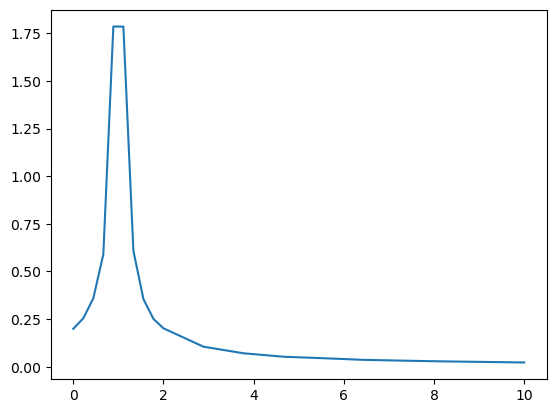

In [233]:
%matplotlib inline

controls = df.control.unique()
mstds = []
bstds = []
#fig, (ax0, ax1) = plt.subplots(1, 2)
for i, control in enumerate(controls):
    tmpdf = df[df.control == control]
#    ax0.hist(tmpdf.m, density=True, color=f"C{i}", alpha=0.2, label=f"x={control}")
#    ax1.hist(tmpdf.b, density=True, color=f"C{i}", alpha=0.2, label=f"x={control}")
#    ax0.set_title(f"m={np.std(tmpdf.m)}")
#    ax1.set_title(f"b={np.std(tmpdf.b)}")

    mstds.append(tmpdf.m.std())
    bstds.append(tmpdf.b.std())

#ax0.set_xlim([0.6, 1.4])
#ax1.set_xlim([0.6, 1.4])
#ax0.legend()
#plt.show()

plt.figure()
plt.plot(controls, mstds)
plt.show()